# IBM Db2 Event Store - Data Analytics using Python API 

IBM Db2 Event Store is a hybrid transactional/analytical processing (HTAP) system. It extends the Spark SQL interface to accelerate analytics queries. 

This notebook illustrates how the IBM Db2 Event Store can be integrated with multiple popular scientific tools to perform data analytics.

***Pre-Req: Event_Store_Querying_on_Table***

## Setting basic import clauses used by this notebook

In [1]:
%matplotlib inline  

from eventstore.oltp import EventContext
from eventstore.sql import EventSession
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from scipy import stats
import warnings
import datetime

warnings.filterwarnings('ignore')
plt.style.use("fivethirtyeight")

## Setting the IP address to connect to your IBM Db2 Event Store cluster

For this, you will need to find out the connection string to your IBM Db2 Event Store cluster.

Perform the following steps:

- Replace the IP address in the below program code with the IP address of your local host
- Then execute the program cell below. It will connect to the IBM Db2 Event Store cluster in the provided connection string. 

In [2]:
from eventstore.common import ConfigurationReader

ip = "9.30.167.102"

endpoint = ip + ':1101'

print("Endpoint: "+ endpoint)

ConfigurationReader.setConnectionEndpoints(endpoint)

Endpoint: 9.30.167.102:1101


## Opening a database
The following code is used to initialize the spark session and open a database.

Run the command in the next cell to define the database name. 

In [3]:
dbName = "TESTDB"

To run Spark SQL queries, you must set up a Db2 Event Store Spark session. The EventSession class extends the optimizer of the SparkSession class.

In [4]:
sparkSession = SparkSession.builder.appName("EventStore SQL in Python").getOrCreate()
eventSession = EventSession(sparkSession.sparkContext, dbName)

Now you can execute the command to open the database in the event session you created:

In [5]:
eventSession.open_database()

## Access an existing table in the database
The following code section retrieves the names of all tables that exist in the database.

In [6]:
with EventContext.get_event_context(dbName) as ctx:
   print("Event context successfully retrieved.")

table_names = ctx.get_names_of_tables()
for idx, name in enumerate(table_names):
   print(name)

Event context successfully retrieved.
IOT_TEMP


Now we have the name of the existing table. We then load the corresponding table and get the data frame references to access the table with query. 

In [7]:
tabName = "IOT_TEMP"

In [8]:
tab = eventSession.load_event_table(tabName)
print("Table "+tabName+" successfully loaded.")

Table IOT_TEMP successfully loaded.


The next code retrieves the schema of the table we want to investigate:

In [9]:
try:
    resolved_table_schema = ctx.get_table(tabName)
    print(resolved_table_schema)
except Exception as err:
    print("Table not found")

ResolvedTableSchema(tableName=IOT_TEMP, schema=StructType(List(StructField(deviceID,IntegerType,false),StructField(sensorID,IntegerType,false),StructField(ts,LongType,false),StructField(ambient_temp,DoubleType,false),StructField(power,DoubleType,false),StructField(temperature,DoubleType,false))), sharding_columns=[u'deviceID', u'sensorID'], pk_columns=[u'deviceID', u'sensorID', u'ts'], partition_columns=None)


And in the following cell we create a temp view with that data frame called `readings` hat we will use in the queries below.

In [10]:
tab.createOrReplaceTempView("readings")

## Data Analytics with IBM Db2 Event Store
Data analytics tasks can be performed on table stored in the IBM Db2 Event Store database with various data analytic tools. 

Let's first take a look at the timestamp range of the record

In [11]:
query = "SELECT MIN(ts) MIN_TS, MAX(ts) MAX_TS FROM readings"
print("{}\nRunning query in Event Store...".format(query))
df_data = eventSession.sql(query)
df_data.toPandas()

SELECT MIN(ts) MIN_TS, MAX(ts) MAX_TS FROM readings
Running query in Event Store...


,MIN_TS,MAX_TS
0,1541019342674,1541774000106


The following cell converts the timestamps in miliseconds to datetime to make it human readable

In [12]:
MIN_TS=1541019342393
MAX_TS=1541773999825
print("The time range of the dataset is from {} to {}".format(datetime.datetime.fromtimestamp(MIN_TS/1000).strftime('%Y-%m-%d %H:%M:%S'), 
                                                               datetime.datetime.fromtimestamp(MAX_TS/1000).strftime('%Y-%m-%d %H:%M:%S')))

The time range of the dataset is from 2018-10-31 20:55:42 to 2018-11-09 14:33:19


## Sample Problem
Assume we are only interested in the data recorded by the 12th sensor on the 1st device in the time period on the day of 2018-11-01. And we want to investigate the effects of power consumption and ambient power on the temperature recorded by the sensor in this date.


Because the timestamp is recorded in milisec, we need to convert the datetime of interest to a time range in milisec. And then use the range as a filter in the query.

In [13]:
start_ts = (datetime.datetime(2018,11,1,0,0) - datetime.datetime(1970,1,1)).total_seconds() * 1000
end_ts = (datetime.datetime(2018,11,2,0,0) - datetime.datetime(1970,1,1)).total_seconds() * 1000
print("The time range of datetime 2018-11-01 in milisec is from {:.0f} to {:.0f}".format(start_ts, end_ts))

The time range of datetime 2018-11-01 in milisec is from 1541030400000 to 1541116800000


IBM Db2 Event Store extends the Spark SQL functionality, which allows users to apply filters at ease.  

In the following cell, the relevant data are extracted according to the problem scope. Note that because we are specifying a specific device and sensor, this query is fully exploiting the index defined.

In [14]:
query = "SELECT * FROM readings WHERE deviceID=1 AND sensorID=12 AND ts >1541030400000 AND ts < 1541116800000 ORDER BY ts"
print("{}\nRunning query in Event Store...".format(query))
refined_data = eventSession.sql(query)
refined_data.createOrReplaceTempView("refined_reading")
refined_data.toPandas()

SELECT * FROM readings WHERE deviceID=1 AND sensorID=12 AND ts >1541030400000 AND ts < 1541116800000 ORDER BY ts
Running query in Event Store...


,deviceID,sensorID,ts,ambient_temp,power,temperature
0,1,12,1541030426769,24.102049,10.080635,39.871122
1,1,12,1541030441897,22.554787,6.494610,35.423241
2,1,12,1541030550911,25.744058,12.723047,44.068345
3,1,12,1541030581867,26.519907,11.159456,45.342386
4,1,12,1541030590110,28.084583,9.730353,43.035403
5,1,12,1541030647015,28.048428,7.832767,44.802226
6,1,12,1541030879275,23.977567,17.530433,46.134688
7,1,12,1541031075284,24.955856,7.798285,37.885606
8,1,12,1541031101226,22.686532,10.960180,40.068903
9,1,12,1541031137295,22.480435,5.577383,38.472545


### Basic Statistics 
For numerical data, knowing the descriptive summary statistics can help a lot in understanding the distribution of the data.  

IBM Event Store extends the Spark DataFrame functionality. We can use the `describe` function to retrieve multiple statistics of table stored in IBM Event Store database.

In [15]:
refined_data.describe().toPandas()

,summary,deviceID,sensorID,ts,ambient_temp,power,temperature
0,count,1154,1154,1154,1154,1154,1154
1,mean,1.0,12.0,1.5410726398507998E12,24.555126885440202,9.905240274817766,41.849253149048536
2,stddev,0.0,0.0,2.527151795033034E7,2.014485755658606,2.9747790618012155,3.3156795533110435
3,min,1,12,1541030426769,17.214787505318053,-0.17717523067801366,31.05307434547659
4,max,1,12,1541116452846,32.2908703083194,20.38135340138372,53.630966958059055


It's worth noticing that some power reading records are negative, which may be caused by sensor error. The records with negative power reading will be dropped.

In [16]:
query = "SELECT * FROM readings WHERE deviceID=1 AND sensorID=12 AND ts >1541030400000 AND ts < 1541116800000 AND power > 0 ORDER BY ts"
print("{}\nRunning query in Event Store...".format(query))
refined_data = eventSession.sql(query)
refined_data.createOrReplaceTempView("refined_reading")

SELECT * FROM readings WHERE deviceID=1 AND sensorID=12 AND ts >1541030400000 AND ts < 1541116800000 AND power > 0 ORDER BY ts
Running query in Event Store...


Total number of records in the refined table view

In [17]:
query = "SELECT count(*) count FROM refined_reading"
print("{}\nRunning query in Event Store...".format(query))
df_data = eventSession.sql(query)
df_data.toPandas()

SELECT count(*) count FROM refined_reading
Running query in Event Store...


,count
0,1153


### Covariance and correlation
- Covariance is a measure of how two variables change with respect to each other. It can be examined by calling `.stat.cov()` function on the table.

In [18]:
refined_data.stat.cov("ambient_temp","temperature")

5.161371904707058

In [19]:
refined_data.stat.cov("power","temperature")

3.823507483080068

- Correlation is a normalized measure of covariance that is easier to understand, as it provides quantitative measurements of the statistical dependence between two random variables.  It can be examined by calling `.stat.corr()` function on the table.

In [20]:
refined_data.stat.corr("ambient_temp","temperature")

0.7726562643481537

In [21]:
refined_data.stat.corr("power","temperature")

0.3892930553822372

### Visualization
Visualization of each feature provides insights of the underlying distributions.

- Distribution of Ambient Temperature

In [22]:
query = "SELECT ambient_temp FROM refined_reading"
print("{}\nRunning query in Event Store...".format(query))
ambient_temp = eventSession.sql(query)
ambient_temp= ambient_temp.toPandas()
ambient_temp.head()

SELECT ambient_temp FROM refined_reading
Running query in Event Store...


,ambient_temp
0,24.102049
1,22.554787
2,25.744058
3,26.519907
4,28.084583


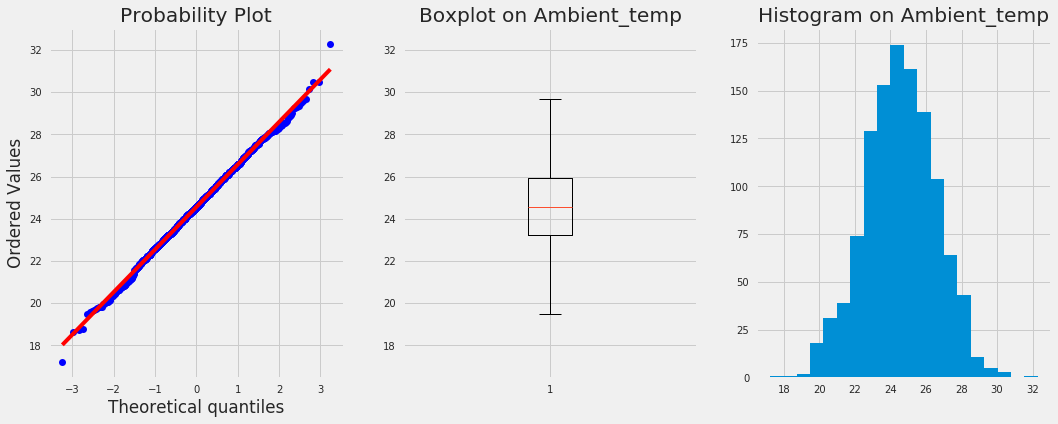

In [23]:
fig, axs = plt.subplots(1,3, figsize=(16,6))
stats.probplot(ambient_temp.iloc[:,0], plot=plt.subplot(1,3,1))
axs[1].boxplot(ambient_temp.iloc[:,0])
axs[1].set_title("Boxplot on Ambient_temp")
axs[2].hist(ambient_temp.iloc[:,0], bins = 20)
axs[2].set_title("Histogram on Ambient_temp")

- Distribution of Power Consumption

In [24]:
query = "SELECT power FROM refined_reading"
print("{}\nRunning query in Event Store...".format(query))
power = eventSession.sql(query)
power= power.toPandas()
power.head()

SELECT power FROM refined_reading
Running query in Event Store...


,power
0,10.080635
1,6.494610
2,12.723047
3,11.159456
4,9.730353


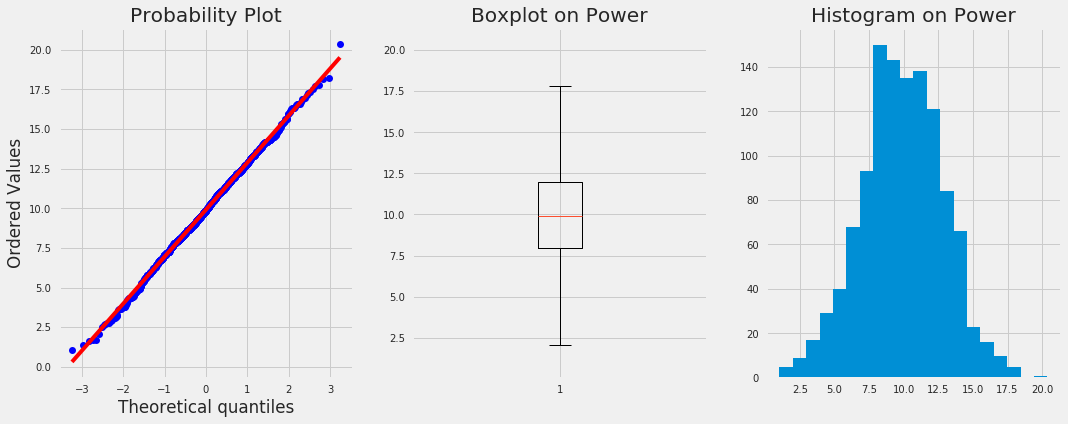

In [25]:
fig, axs = plt.subplots(1,3, figsize=(16,6))
stats.probplot(power.iloc[:,0], plot=plt.subplot(1,3,1))
axs[1].boxplot(power.iloc[:,0])
axs[1].set_title("Boxplot on Power")
axs[2].hist(power.iloc[:,0], bins = 20)
axs[2].set_title("Histogram on Power")

- Distribution of Sensor Temperature

In [26]:
query = "SELECT temperature FROM refined_reading"
print("{}\nRunning query in Event Store...".format(query))
temperature = eventSession.sql(query)
temperature= temperature.toPandas()
temperature.head()

SELECT temperature FROM refined_reading
Running query in Event Store...


,temperature
0,39.871122
1,35.423241
2,44.068345
3,45.342386
4,43.035403


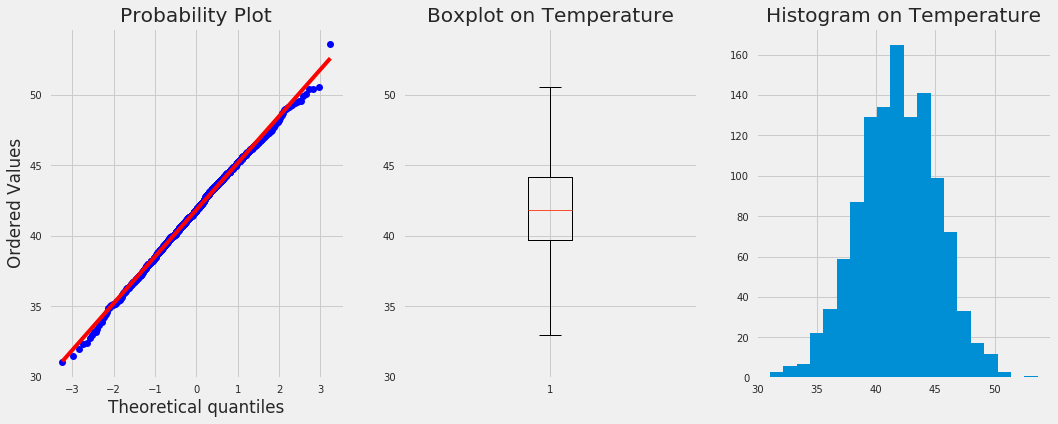

In [27]:
fig, axs = plt.subplots(1,3, figsize=(16,6))
stats.probplot(temperature.iloc[:,0], plot=plt.subplot(1,3,1))
axs[1].boxplot(temperature.iloc[:,0])
axs[1].set_title("Boxplot on Temperature")
axs[2].hist(temperature.iloc[:,0], bins = 20)
axs[2].set_title("Histogram on Temperature")

- Input-variable vs. Target-variable

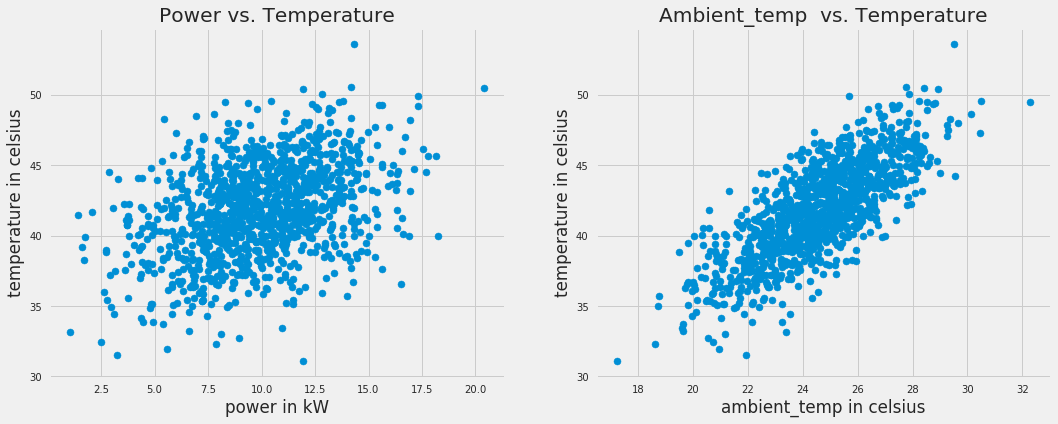

In [28]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
axs[0].scatter(power.iloc[:,0], temperature.iloc[:,0])
axs[0].set_xlabel("power in kW")
axs[0].set_ylabel("temperature in celsius")
axs[0].set_title("Power vs. Temperature")
axs[1].scatter(ambient_temp.iloc[:,0], temperature.iloc[:,0])
axs[1].set_xlabel("ambient_temp in celsius")
axs[1].set_ylabel("temperature in celsius")
axs[1].set_title("Ambient_temp  vs. Temperature")

**By observing the plots above, we noticed:**
- The distribution of power consumption, ambient temperature, and sensor temperature each follows an roughly normal distribution.
- The scatter plot shows the sensor temperature has linear relationships with power consumption and ambient temperature.

## Summary
This demo introduced you to how to perform data analytics using IBM Db2 Event Store.

## Next Step
`"Event_Store_ML_Model_Deployment.ipynb"` will show you how to build machine learning model and deploy the model with IBM Db2 Event Store.